In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [2]:

file_list = []
for dirname, _, filenames in os.walk('D:\ML Project\input'):
    for filename in filenames:
        file_list.append((dirname,filename)) 
df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\ADM\AppData\Local\Temp\ipykernel_35208\366511757.py:2: SyntaxWarning: invalid escape sequence '\M'
  for dirname, _, filenames in os.walk('D:\ML Project\input'):


,dirname,filename
0,D:\ML Project\input\segmentations,segmentation-0.nii
1,D:\ML Project\input\segmentations,segmentation-1.nii
2,D:\ML Project\input\segmentations,segmentation-10.nii
3,D:\ML Project\input\segmentations,segmentation-100.nii
4,D:\ML Project\input\segmentations,segmentation-101.nii
...,...,...
227,D:\ML Project\input\volume_pt6,volume-95.nii
228,D:\ML Project\input\volume_pt6,volume-96.nii
229,D:\ML Project\input\volume_pt6,volume-97.nii
230,D:\ML Project\input\volume_pt6,volume-98.nii


In [3]:
df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "input/segmentations"

df_files_test= df_files[df_files.mask_filename=='']
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

131


,dirname,filename,mask_dirname,mask_filename
0,D:\ML Project\input\volume_pt1,volume-0.nii,input/segmentations,segmentation-0.nii
1,D:\ML Project\input\volume_pt1,volume-1.nii,input/segmentations,segmentation-1.nii
2,D:\ML Project\input\volume_pt1,volume-10.nii,input/segmentations,segmentation-10.nii
3,D:\ML Project\input\volume_pt6,volume-100.nii,input/segmentations,segmentation-100.nii
4,D:\ML Project\input\volume_pt8,volume-101.nii,input/segmentations,segmentation-101.nii
...,...,...,...,...
126,D:\ML Project\input\volume_pt6,volume-95.nii,input/segmentations,segmentation-95.nii
127,D:\ML Project\input\volume_pt6,volume-96.nii,input/segmentations,segmentation-96.nii
128,D:\ML Project\input\volume_pt6,volume-97.nii,input/segmentations,segmentation-97.nii
129,D:\ML Project\input\volume_pt6,volume-98.nii,input/segmentations,segmentation-98.nii


In [4]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape) 
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 75)
(512, 512, 75)
D:\ML Project\input\volume_pt1/volume-0.nii


In [6]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


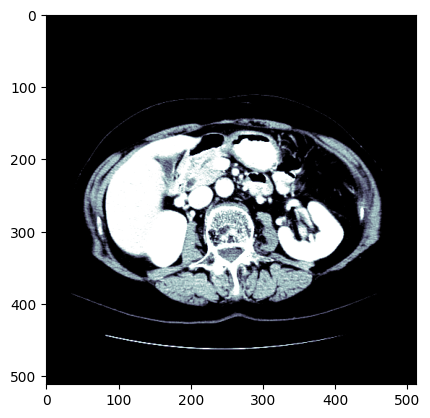

In [7]:
dicom_windows = types.SimpleNamespace(
    liver=(150,30),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [8]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

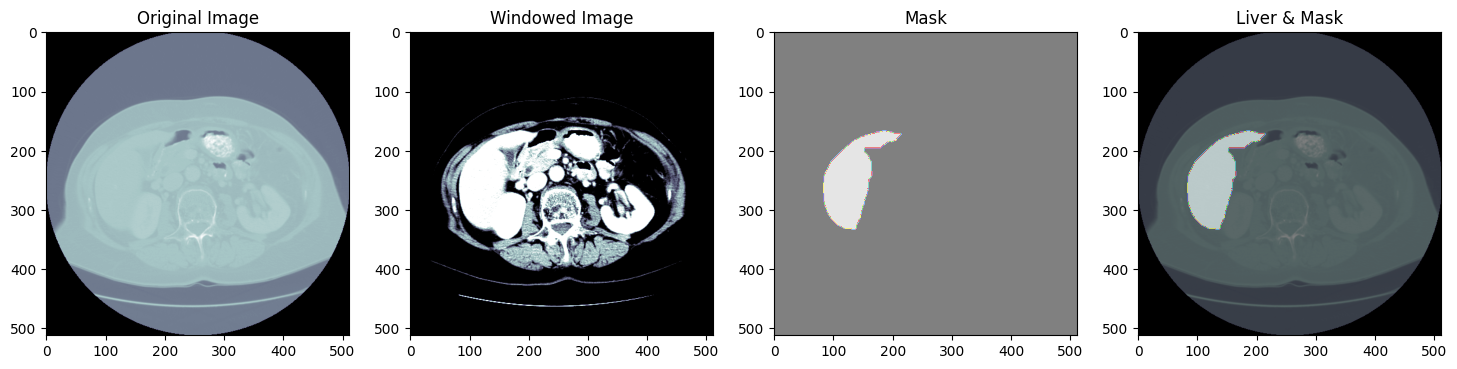

In [9]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [10]:
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


<Axes: >

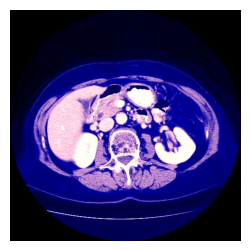

In [11]:
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    ''''"A function to split the range of pixel values into groups, 
    such that each group has around the same number of pixels"'''
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [12]:
df_files_1=df_files[0:30]
df_files_1

,dirname,filename,mask_dirname,mask_filename
0,D:\ML Project\input\volume_pt1,volume-0.nii,input/segmentations,segmentation-0.nii
1,D:\ML Project\input\volume_pt1,volume-1.nii,input/segmentations,segmentation-1.nii
2,D:\ML Project\input\volume_pt1,volume-10.nii,input/segmentations,segmentation-10.nii
3,D:\ML Project\input\volume_pt6,volume-100.nii,input/segmentations,segmentation-100.nii
4,D:\ML Project\input\volume_pt8,volume-101.nii,input/segmentations,segmentation-101.nii
5,D:\ML Project\input\volume_pt8,volume-102.nii,input/segmentations,segmentation-102.nii
6,D:\ML Project\input\volume_pt8,volume-103.nii,input/segmentations,segmentation-103.nii
7,D:\ML Project\input\volume_pt8,volume-104.nii,input/segmentations,segmentation-104.nii
8,D:\ML Project\input\volume_pt8,volume-105.nii,input/segmentations,segmentation-105.nii
9,D:\ML Project\input\volume_pt8,volume-106.nii,input/segmentations,segmentation-106.nii


In [13]:
import random

GENERATE_JPG_FILES = True  

if GENERATE_JPG_FILES:
    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)


    random_indices = random.sample(range(len(df_files)), len(df_files) // 2)

    for ii in tqdm(range(len(df_files))):  
        curr_ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        curr_mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        curr_file_name = str(df_files.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]  

        for curr_slice in range(0, curr_dim, 2):  
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2")

  0%|          | 0/131 [00:00<?, ?it/s]

In [14]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

images_dir = 'train_images'
masks_dir = 'train_masks'
save_masks_dir = 'masks'

all_image_file_names = sorted(os.listdir(images_dir))

selected_image_file_names = random.sample(all_image_file_names, 9000)

target_size = (256, 256)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

images = np.array(images)
masks = np.array(masks)

images = images / 255.0

masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

In [24]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Directories
images_dir = 'train_images'
masks_dir = 'train_masks'
save_masks_dir = 'masks'

# Ensure the save_masks_dir exists
os.makedirs(save_masks_dir, exist_ok=True)

# Get all image file names and select a sample of 9000
all_image_file_names = sorted(os.listdir(images_dir))
selected_image_file_names = random.sample(all_image_file_names, 9000)

# Define the target size for resizing images and masks
target_size = (256, 256)

def load_image(image_path):
    return np.array(Image.open(image_path).resize(target_size))

def load_mask(mask_path):
    return np.array(Image.open(mask_path).resize(target_size)).reshape(target_size + (1,))

# Generate corresponding mask filenames
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]

# Split the data into training, validation, and test sets
train_image_files, temp_image_files, train_mask_files, temp_mask_files = train_test_split(
    selected_image_file_names, mask_file_names, test_size=0.3, random_state=42
)
valid_image_files, test_image_files, valid_mask_files, test_mask_files = train_test_split(
    temp_image_files, temp_mask_files, test_size=1/3, random_state=42
)

# Save each y_train mask to the save_masks_dir
for i, mask_file in enumerate(train_mask_files):
    mask = load_mask(os.path.join(masks_dir, mask_file))
    mask_image = Image.fromarray((mask.squeeze() * 255).astype(np.uint8))
    mask_image.save(os.path.join(save_masks_dir, f'mask_{i}.png'))

print(f'Saved {len(train_mask_files)} mask images to {save_masks_dir}')


Saved 6300 mask images to masks


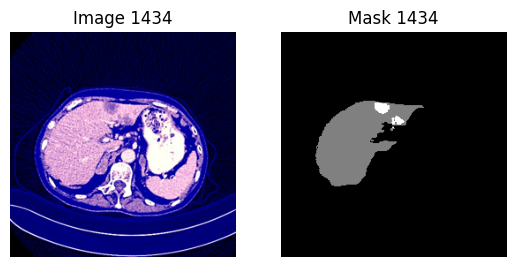

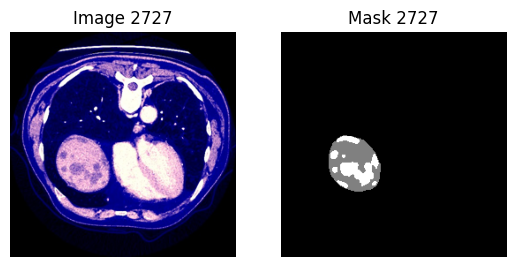

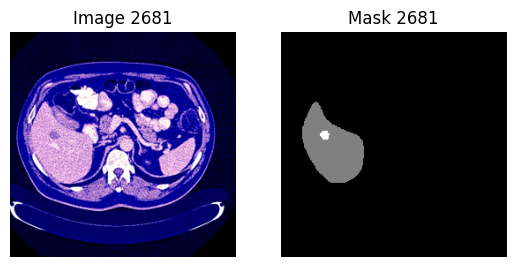

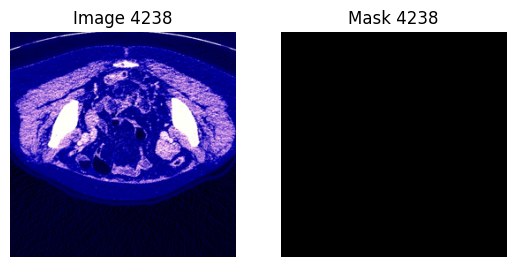

In [27]:
import matplotlib.pyplot as plt

def display_images_and_masks(images, masks, num_samples=1):
    sample_indices = random.sample(range(images.shape[0]), num_samples)

    for i in range(num_samples):
        index = sample_indices[i]

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")

    plt.show()

for i in range (4):
    display_images_and_masks(x_train, y_train)

In [ ]:
y_train.shape, x_train.shape

((6300, 256, 256, 1), (6300, 256, 256, 3))

In [24]:
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from skimage.transform import resize

@st.cache(allow_output_mutation=True)
def load_trained_model():
    model = tf.keras.models.load_model('segnet_model.keras')
    return model

def preprocess_image(image, target_size=(128, 128)):
    img = image.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def jaccard_index(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union != 0 else 0

st.title("Классификация изображений печени")

uploaded_image_file = st.file_uploader("Загрузите изображение для классификации", type=["jpeg", "jpg", "png"])
if uploaded_image_file is not None:
    image = Image.open(uploaded_image_file)
    st.image(image, caption='Загруженное изображение', use_column_width=True)

    preprocessed_image = preprocess_image(image)

    model = load_trained_model()

    prediction = model.predict(preprocessed_image)

    mask_threshold = st.slider("Порог для маски", 0.0, 1.0, 0.5)
    predicted_mask = (prediction > mask_threshold).astype(np.uint8)

    st.image(predicted_mask * 255, caption='Предсказанная маска', use_column_width=True)
    
    true_mask = np.array(image) 
    true_mask = resize(true_mask, (128, 128), anti_aliasing=True)
    true_mask = (true_mask > 0.5).astype(np.uint8)

    jaccard = jaccard_index(true_mask, predicted_mask)
    st.write("Индекс Жаккара:", jaccard)

